# installs - imports - paths...

In [ ]:
import os
import os
import pandas as pd
import ast
import numpy as np

import sys
!{sys.executable} -m pip install --upgrade pyarrow
!{sys.executable} -m pip install --upgrade fastparquet
!pip install matplotlib
!{sys.executable} -m pip install --upgrade scikit-learn
!pip install torch
!{sys.executable} -m pip install scikit-learn --upgrade
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from torch.utils.data import TensorDataset, DataLoader

path = r'C:\Users\julia\OneDrive\Desktop\HPE'
print(os.listdir(path))


['.venv', 'cluster-data', 'DS-HPE', 'DS-HPE1', 'HPE Optimization of power consumption_team1.pdf', 'hpe-uc3m-kickoff.pptx', 'IndividualReport2_JuliaVidarte.pdf', 'IndividualReport_JuliaVidarte.pdf', 'iqbal_new_MP100_2_models.ipynb', 'job_table.csv', 'job_table.parquet']


# AUTOML MANUAL - XGBOOST con hyper

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model_train_test(model, X_train, y_train, X_test, y_test, model_type: str = "sklearn"):
    
    model.fit(X_train, y_train)

    if model_type == "sklearn":
        y_pred = model.predict(X_test)
    else:  
        model.eval()
        device = next(model.parameters()).device
        with torch.no_grad():

            X_test_encoded  = pd.get_dummies(X_test, drop_first=False)
            # Convert to float32 NumPy arrays
            X_test_array = X_test_encoded.to_numpy(dtype=np.float32)
            # Convert to tensors (on CPU)
            X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)
            #X_test_tensor = torch.tensor(X_test_numeric, dtype=torch.float32).to(device)
            #print(X_test.dtypes)
            #X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
            y_pred = model(X_test_tensor).cpu().numpy()
    
    metrics = {}
    target_names = ["mean_power", "min_power", "max_power"]
    
    for i, name in enumerate(target_names):
        rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        mape = np.mean(np.abs((y_test[:, i] - y_pred[:, i]) / y_test[:, i])) * 100
        
        metrics[f"test_rmse_{name}"] = rmse
        metrics[f"test_mae_{name}"] = mae
        metrics[f"test_r2_{name}"] = r2
        metrics[f"test_mape_{name}"] = mape
    
    # Overall metrics
    metrics["test_rmse_mean"] = np.mean([metrics[f"test_rmse_{name}"] for name in target_names])
    metrics["test_mae_mean"] = np.mean([metrics[f"test_mae_{name}"] for name in target_names])
    metrics["test_r2_mean"] = np.mean([metrics[f"test_r2_{name}"] for name in target_names])
    metrics["test_mape_mean"] = np.mean([metrics[f"test_mape_{name}"] for name in target_names])
    
    return metrics, y_pred

In [ ]:
import pandas as pd
import numpy as np

def prepare_df(df):
    # Time features
    df["dow"] = pd.to_datetime(df["submit_time"]).dt.dayofweek
    df["dom"] = pd.to_datetime(df["submit_time"]).dt.day
    df["hour"] = pd.to_datetime(df["submit_time"]).dt.hour
    df["month"] = pd.to_datetime(df["submit_time"]).dt.month

    df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
    df["is_night"] = ((df["hour"] < 7) | (df["hour"] >= 22)).astype(int)
    df["is_peak"] = df["hour"].between(9, 18).astype(int)

    df.drop(columns=["submit_time"], inplace=True)

    # Drop OHE leftovers if any
    cols_to_drop = (
        df.filter(like="dow_").columns.tolist()
        + df.filter(like="dom_").columns.tolist()
        + df.filter(like="hour_").columns.tolist()
    )
    df.drop(columns=cols_to_drop, errors="ignore", inplace=True)

    # Encode categoricals
    for col in ["group", "time_limit_cat"]:
        df[col] = df[col].astype("category").cat.codes

    return df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

BASE_PATH = "C:/Users/julia/OneDrive/Desktop/HPE/DS-HPE"

month_map = { 
    1 : 5, 
    2: 6,
    3 : 7,
    4 : 8,
    5 : 9, 
    6 : 10  
}

def automl(approach):
    """computes an evaluation of the metrics for the three targets using the CGBoost model, 
    following the three approaches to cover all months available
    returns: 
        line plot of the evolution of MAPE, for each approach"""

    # use best hyperparameters combination found in the sweeps
    best_model = MultiOutputRegressor(
        xgb.XGBRegressor(
            tree_method="hist",
            enable_categorical=True,
            n_estimators=500,
            max_depth=10,
            learning_rate=0.011957603924852534,
            subsample=0.60515888233175461,
            colsample_bytree=0.7835834755878521,
            min_child_weight=7,
            random_state=42,
        )
    )

    feature_cols = [
        "group",
        "num_tasks_final",
        "num_tasks_missing_or_inconsistent",
        "time_limit_scaled",
        "time_limit_cat",
        "num_nodes_req",
        "has_req_nodes",
        "num_cores_req",
        "cores_per_task",
        "num_gpus_req",
        "mem_req",
        "has_req_threads_per_core",
        "is_shared_job",
        "dow", "dom", "hour",
        "is_weekend", "month",
        "is_night", "is_peak"
    ]


    mape_history = {
        "mean_power": [],
        "min_power": [],
        "max_power": [],
    }
    iterations = []


    target_cols = [
        "node_power_min",
        "node_power_mean",
        "node_power_max"
    ]

    for i in [1, 2, 3, 4, 5, 6]:

        # LOAD THE DATA FOLLOWING THE APPROACH
        if approach == "accumulative":
            df = pd.read_csv(f"{BASE_PATH}/my_dataframe{i}.csv", low_memory=False)
            df = prepare_df(df)

            X = df[feature_cols]
            y = df[target_cols]

            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, test_size=0.3, random_state=42
            )
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=42
            )

            # Train on train + val
            X_train_full = pd.concat([X_train, X_val])
            y_train_full = pd.concat([y_train, y_val])

            iterations.append(f"{i} months")

        elif approach == "pairs":
            if i < 6:
                df = pd.read_csv(f"{BASE_PATH}/my_dataframe2{i}.csv", low_memory=False)
                df = prepare_df(df)

                X = df[feature_cols]
                y = df[target_cols]

                X_train, X_temp, y_train, y_temp = train_test_split(
                    X, y, test_size=0.3, random_state=42
                )
                X_val, X_test, y_val, y_test = train_test_split(
                    X_temp, y_temp, test_size=0.5, random_state=42
                )

                X_train_full = pd.concat([X_train, X_val])
                y_train_full = pd.concat([y_train, y_val])

                iterations.append(f"pair {month_map[i]}-{month_map[i+1]}")
            else:
                continue            

        elif approach == "future-testing":
            if i < 6:
                df_train = pd.read_csv(f"{BASE_PATH}/my_dataframe{i}.csv", low_memory=False)
                df_test = pd.read_csv(f"{BASE_PATH}/my_dataframe3{i+1}.csv", low_memory=False)
                
                iterations.append(f"acc.{month_map[i]}-0{month_map[i+1]}")

            if i == 6:
                df_train = pd.read_csv(f"{BASE_PATH}/my_dataframe{i}.csv", low_memory=False)
                df_test = pd.read_csv(f"{BASE_PATH}/my_dataframe3{i}.csv", low_memory=False)
                iterations.append(f"all acc.-0{month_map[i]}")

            df_train = prepare_df(df_train)
            df_test = prepare_df(df_test)

            X_train_full = df_train[feature_cols]
            y_train_full = df_train[target_cols]

            X_test = df_test[feature_cols]
            y_test = df_test[target_cols]


        else:
            raise ValueError("Unknown approach")

        # train and evaluate 
        metrics_test, y_pred_test = evaluate_model_train_test(
            best_model,
            X_train_full.to_numpy(),
            y_train_full.to_numpy(),
            X_test.to_numpy(),
            y_test.to_numpy(),
        )

        structured = {
            "mean_power": {
                "rmse (w)": metrics_test["test_rmse_mean_power"],
                "mae (w)": metrics_test["test_mae_mean_power"],
                "r2": metrics_test["test_r2_mean_power"],
                "mape %": metrics_test["test_mape_mean_power"],
            },
            "min_power": {
                "rmse (w)": metrics_test["test_rmse_min_power"],
                "mae (w)": metrics_test["test_mae_min_power"],
                "r2": metrics_test["test_r2_min_power"],
                "mape %": metrics_test["test_mape_min_power"],
            },
            "max_power": {
                "rmse (w)": metrics_test["test_rmse_max_power"],
                "mae (w)": metrics_test["test_mae_max_power"],
                "r2": metrics_test["test_r2_max_power"],
                "mape %": metrics_test["test_mape_max_power"],
            },
        }

        df_metrics = pd.DataFrame(structured).T

        #store the values of the metric for different targets for later plotting
        mape_history["mean_power"].append(metrics_test["test_mape_mean_power"])
        mape_history["min_power"].append(metrics_test["test_mape_min_power"])
        mape_history["max_power"].append(metrics_test["test_mape_max_power"])

    #plot using the stored values from before
    plt.figure()
    plt.plot(iterations, mape_history["mean_power"], marker="o", label="Mean Power")
    plt.plot(iterations, mape_history["min_power"], marker="o", label="Min Power")
    plt.plot(iterations, mape_history["max_power"], marker="o", label="Max Power")

    plt.xlabel("Iteration")
    plt.ylabel("MAPE (%)")
    plt.title(f"MAPE Evolution - {approach}")
    plt.legend()
    plt.grid(True)
    plt.show()


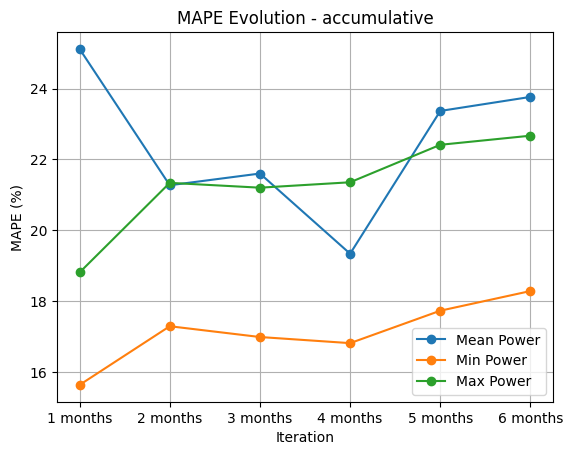

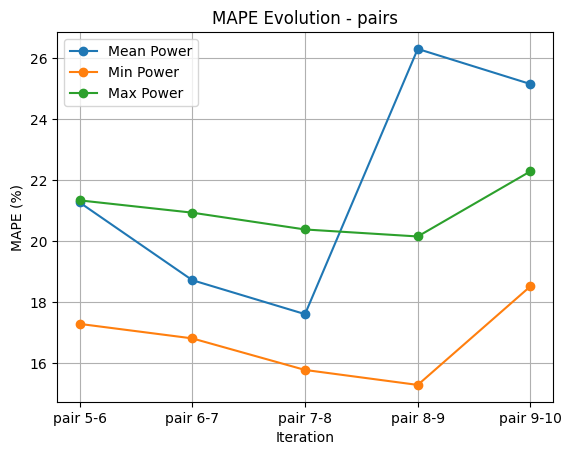

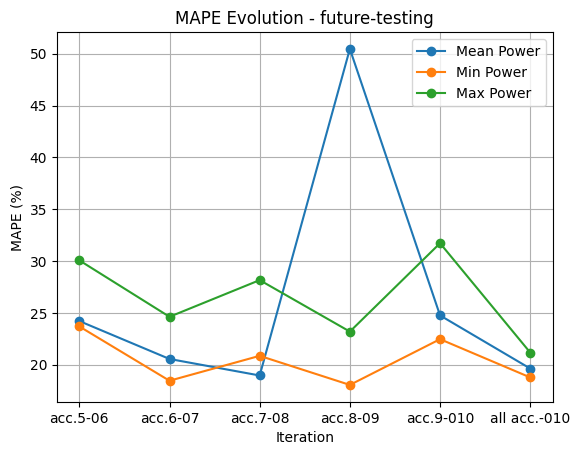

In [ ]:
for approach in ['accumulative', 'pairs', 'future-testing']:
    automl(approach)

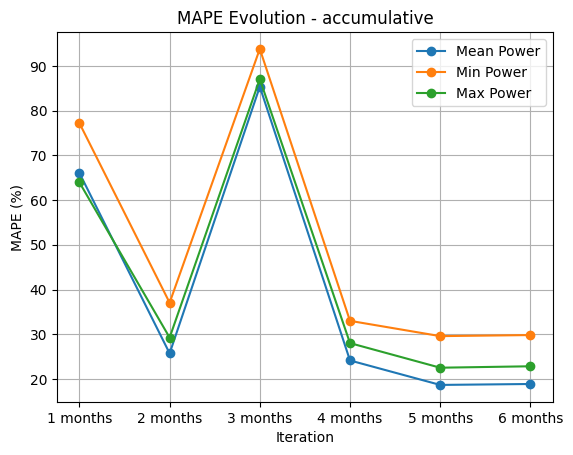

In [11]:
automl_torch_deepmlp("accumulative")

In [ ]:
for a in ['accumulative', 'pairs', 'future-testing']:
    automl_torch_mlp(a)

# resulting dataframes

## paired-month approach

In [14]:
df_metrics1_2=df_metrics
df_metrics1_2

,rmse (w),mae (w),r2,mape %
mean_power,1185.512515,409.148409,0.941760,23.085784
min_power,798.300348,327.005008,0.987790,15.230932
max_power,1277.920826,492.873430,0.979356,18.323049


In [17]:
df_metrics2_3=df_metrics
df_metrics2_3

,rmse (w),mae (w),r2,mape %
mean_power,1262.182398,426.079613,0.933983,23.883726
min_power,827.042287,340.449212,0.986895,15.858294
max_power,1288.310163,512.596323,0.979019,19.215799


In [20]:
df_metrics3_4=df_metrics
df_metrics3_4

,rmse (w),mae (w),r2,mape %
mean_power,1262.067657,428.187058,0.933995,24.138117
min_power,831.207773,345.457540,0.986763,16.188109
max_power,1297.699311,523.287615,0.978712,19.597406


In [23]:
df_metrics4_5=df_metrics
df_metrics4_5

,rmse (w),mae (w),r2,mape %
mean_power,1319.221599,435.427814,0.927882,24.439988
min_power,863.711668,349.938496,0.985707,16.308541
max_power,1337.876483,532.753720,0.977373,19.919239


In [26]:
df_metrics5_6=df_metrics
df_metrics5_6

,rmse (w),mae (w),r2,mape %
mean_power,1354.547303,436.294725,0.923967,24.555896
min_power,863.164979,350.796576,0.985725,16.327924
max_power,1353.964736,539.453734,0.976826,20.079549


## future-testing approach

In [15]:
df_metrics21=df_metrics
df_metrics21

,rmse (w),mae (w),r2,mape %
mean_power,1503.056843,404.703194,0.958369,21.269724
min_power,1149.971029,353.427287,0.982750,17.287719
max_power,1840.786954,509.559996,0.965507,21.337475


In [18]:
df_metrics22=df_metrics
df_metrics22

,rmse (w),mae (w),r2,mape %
mean_power,1766.528701,371.070151,0.972734,18.720782
min_power,1644.785278,379.806560,0.979401,16.812248
max_power,2285.036127,537.746694,0.965529,20.933897


In [21]:
df_metrics23=df_metrics
df_metrics23

,rmse (w),mae (w),r2,mape %
mean_power,2322.907925,426.554837,0.963228,17.607301
min_power,2494.713590,444.897949,0.961967,15.777492
max_power,3548.300889,613.500705,0.934814,20.383250


In [24]:
df_metrics24=df_metrics
df_metrics24

,rmse (w),mae (w),r2,mape %
mean_power,2963.626885,519.767100,0.919002,26.302183
min_power,2199.959750,419.889491,0.965455,15.286751
max_power,2536.709580,548.581271,0.961884,20.153633


In [27]:
df_metrics25=df_metrics
df_metrics25

,rmse (w),mae (w),r2,mape %
mean_power,2740.275898,425.434147,0.887019,25.150423
min_power,1842.689924,347.965596,0.961191,18.521708
max_power,2066.442441,450.723321,0.958018,22.290779


## accumulative approach

In [18]:
df_metrics1=df_metrics
df_metrics1

,rmse (w),mae (w),r2,mape %
mean_power,1931.330856,503.948919,0.845430,25.119986
min_power,1261.796770,386.812697,0.969496,15.630192
max_power,2116.034634,587.933428,0.943398,18.806450


In [15]:
df_metrics2=df_metrics
df_metrics2

,rmse (w),mae (w),r2,mape %
mean_power,1503.056843,404.703194,0.958369,21.269724
min_power,1149.971029,353.427287,0.982750,17.287719
max_power,1840.786954,509.559996,0.965507,21.337475


In [21]:
df_metrics3=df_metrics
df_metrics3

,rmse (w),mae (w),r2,mape %
mean_power,2009.979964,423.972076,0.949746,21.600547
min_power,1643.893415,391.916492,0.972550,16.983226
max_power,2407.262004,572.599699,0.951074,21.201028


In [24]:
df_metrics4=df_metrics
df_metrics4

,rmse (w),mae (w),r2,mape %
mean_power,2226.179330,425.851103,0.951597,19.335857
min_power,2031.188322,418.202319,0.967025,16.810343
max_power,2888.219842,604.225706,0.944513,21.353678


In [27]:
df_metrics5=df_metrics
df_metrics5

,rmse (w),mae (w),r2,mape %
mean_power,1961.113212,433.038587,0.954866,23.368349
min_power,1631.391684,388.617016,0.974147,17.726595
max_power,2252.722976,549.719856,0.958287,22.412268


In [30]:
df_metrics6=df_metrics
df_metrics6

,rmse (w),mae (w),r2,mape %
mean_power,1983.110217,412.778275,0.950827,23.764717
min_power,1683.969924,380.562402,0.971695,18.282003
max_power,2136.019987,520.841390,0.960428,22.669419
